In [98]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import operator
from tqdm import tqdm
import statsmodels.api as sm

In [99]:
def logistic(r,x):
    return r*x*(1-x)

def logistic_orbit(r,n_iter,x_0):
    time_series = []
    x_0 = 0.4
    
    time_series.append(x_0)
    for i in range(n_iter):
        previous = time_series[i]
        new = logistic(r,previous)
        time_series.append(new)
    
    return time_series

In [101]:
def co_occur(region1,region2):
    N = len(region1) # Since length of all ordinal sequences are the same 
    
    co_occur_join = []
    for i in range(N):
        #joined = region1[i] + region2[i]
        joined = (region1[i],region2[i])
        co_occur_join.append(joined)
    
    return co_occur_join

def count_frequency(input_list,highest_freq=True):
    '''
    Count frequency of each unique element in input_list
    '''
    freq = {} # Create empty dictionary
    for item in input_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    if highest_freq==True:
        return dict(sorted(freq.items(),key = operator.itemgetter(1),reverse=True))
    else:
        return freq

# Explore using ordinal partitioning with NO OVERLAP (as we actually intend on doing)

In [102]:
def block_ordinal_sequence(region_choice,window_length):
    '''
    Generate ordinal sequence with NO OVERLAP
    Inputs:
        1) region_choice = m x N array for an m-dimensional time series, where each time series is of length N
        2) window_length = required window length
    '''  
    region_seq_split = []
    for i in range(len(region_choice)):
        time_series = region_choice[i]
        test = [time_series[window_length*x:window_length*x+window_length] for x in range(len(time_series))]
        
        test1 = []
        for j in range(len(test)):
            compare = test[j]
            if len(compare) < window_length:
                pass
            else:
                test1.append(compare)
        region_seq_split.append(test1)
    
    ordinal_patterns = []
    for i in range(len(region_seq_split)):
        thingo = region_seq_split[i]
        
        pattern_seq = []
        for j in range(len(thingo)):
            component = thingo[j]
            pattern = np.argsort(component)
            #pattern_seq.append(str(pattern))
            pattern_seq.append(str(pattern))
        ordinal_patterns.append(np.asarray(pattern_seq))
    
    return ordinal_patterns

# Illustrate Coupling

In [103]:
def coupled_logistic(r,alpha,x_0,y_0,n_iter,transient):
    x_n = np.zeros(n_iter)
    y_n = np.zeros(n_iter)
    
    x_n[0] = x_0
    y_n[0] = y_0
    
    for i in range(n_iter-1):
        x_n[i+1] = (1 - alpha)*r*x_n[i]*(1 - x_n[i]) + alpha*r*y_n[i]*(1 - y_n[i])
        y_n[i+1] = (1 - alpha)*r*y_n[i]*(1 - y_n[i]) + alpha*r*x_n[i]*(1 - x_n[i])
        
    return x_n[transient:],y_n[transient:]

In [171]:
def derived_coupling_strength_no_overlap(window_length,num_samples,r,alpha_min,alpha_max,alpha_step,total_time,transient):
    alphas = np.arange(alpha_min,alpha_max,alpha_step)
    
    all_couplings = []
    for i in tqdm(range(num_samples)):
        x_0 = np.random.uniform(0,1)
        y_0 = np.random.uniform(0,1)
        
        couplings = []
        for j in range(len(alphas)):
            alpha = alphas[j]
            
            block_log = np.asarray(coupled_logistic(r,alpha,x_0,y_0,total_time,transient))
            
            ord_seq_x,ord_seq_y = block_ordinal_sequence(block_log,window_length)
            
            freq_dict = count_frequency(co_occur(ord_seq_x,ord_seq_y))
            coupling = len(freq_dict)
            
            couplings.append(coupling/math.factorial(window_length))
            
        all_couplings.append(couplings)
        
    mean_coupling = np.mean(all_couplings,axis=0)

    return alphas,mean_coupling

In [165]:
def cross_correlation_plot(r,alpha_min,alpha_max,alpha_step,total_time,transient):
    import statsmodels.api as sm
    
    alphas = np.arange(alpha_min,alpha_max,alpha_step)
    
    x_0 = np.random.uniform(0,1)
    y_0 = np.random.uniform(0,1)
    
    cross_correlation = []
    for i in tqdm(range(len(alphas))):
        alpha = alphas[i]
        x,y = coupled_logistic(4,alpha,x_0,y_0,total_time,transient)
        cross = sm.tsa.stattools.ccf(x,y,adjusted=False)
        max_ting = max(cross)
        cross_correlation.append(max_ting)
    
    return cross_correlation

In [179]:
num_samples = 10
r = 4
alpha_min = 0
alpha_max = 0.5
alpha_step = 0.005
total_time = 100000
transient = 20000

derived_4 = derived_coupling_strength_no_overlap(4,
                                                 num_samples,
                                                 r,
                                                 alpha_min,
                                                 alpha_max,
                                                 alpha_step,
                                                 total_time,
                                                 transient)
derived_5 = derived_coupling_strength_no_overlap(5,
                                                 num_samples,
                                                 r,
                                                 alpha_min,
                                                 alpha_max,
                                                 alpha_step,
                                                 125000,
                                                 25000)
derived_6 = derived_coupling_strength_no_overlap(6,
                                                 num_samples,
                                                 r,
                                                 alpha_min,
                                                 alpha_max,
                                                 alpha_step,
                                                 150000,
                                                 30000)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [44:42<00:00, 268.29s/it]


In [184]:
derived_12 = derived_coupling_strength_no_overlap(12,
                                                 10,
                                                 r,
                                                 alpha_min,
                                                 alpha_max,
                                                 alpha_step,
                                                 300000,
                                                 60000)

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:16:56<00:00, 461.63s/it]


In [186]:
cross_corr_totals = []
for i in range(num_samples):
    x_corr = cross_correlation_plot(r,alpha_min,alpha_max,alpha_step,total_time,transient)
    cross_corr_totals.append(x_corr)
cross_correlation = np.mean(cross_corr_totals,axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


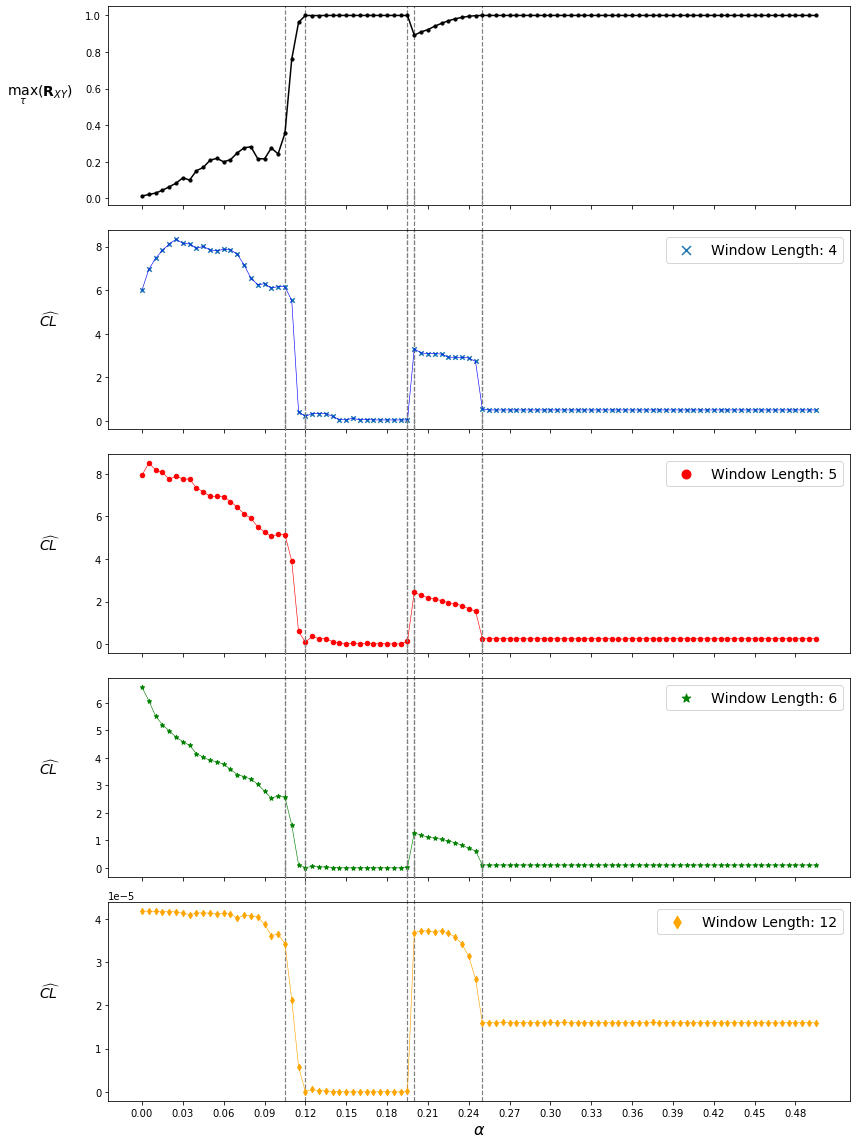

In [190]:
fontsize=14
skip = 1
markerscale = 2

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 16),sharex=True)

#ax1.plot(actual_deviation[0],actual_deviation[1],c='k')
#ax1.scatter(actual_deviation[0][::2],actual_deviation[1][::2],c='k')
#ax1.set_ylabel(r'$E(\alpha)$',fontsize=fontsize)

#ax1.plot(test[0],test[1],c='k')
#ax1.scatter(test[0],test[1],c='k',s=10)
#ax1.set_ylabel(r'$I(X,y)$',fontsize=fontsize)

ax1.plot(np.arange(alpha_min,alpha_max,alpha_step),cross_correlation,c='k')
ax1.scatter(np.arange(alpha_min,alpha_max,alpha_step),cross_correlation,c='k',s=10)
#ax1.plot(alphas,test,c='k')
#ax1.scatter(alphas,test,c='k',s=10)
ax1.set_ylabel(r'$\max_{\tau}{(\mathbf{R}_{XY})}$',fontsize=fontsize,rotation=0,labelpad=45)

ax2.plot(derived_4[0],derived_4[1],c='blue',linewidth=0.6)
ax2.scatter(derived_4[0][::skip],derived_4[1][::skip],marker='x',label='Window Length: 4',s=20)
ax2.set_ylabel(r'$\widehat{CL}$',fontsize=fontsize,rotation=0,labelpad=45)
ax2.legend(fontsize=fontsize,markerscale = markerscale)
ax2.set_xticks(derived_4[0][::6])

ax3.plot(derived_5[0],derived_5[1],c='red',linewidth=0.6)
ax3.scatter(derived_5[0][::skip],derived_5[1][::skip],marker='o',label='Window Length: 5',c='red',s=20)
ax3.set_ylabel(r'$\widehat{CL}$',fontsize=fontsize, rotation=0,labelpad=45)
ax3.legend(fontsize=fontsize, markerscale = markerscale)
ax3.set_xticks(derived_4[0][::6])

ax4.plot(derived_6[0],derived_6[1],c='green',linewidth=0.6)
ax4.scatter(derived_6[0][::skip],derived_6[1][::skip],marker='*',label='Window Length: 6',c='green',s=20)
ax4.set_ylabel(r'$\widehat{CL}$',fontsize=fontsize,rotation=0,labelpad=45)
ax4.legend(fontsize=fontsize, markerscale = markerscale)
ax4.set_xticks(derived_4[0][::6])

ax5.plot(derived_12[0],derived_12[1],c='orange',linewidth=0.6)
ax5.scatter(derived_12[0][::skip],derived_12[1][::skip],marker='d',label='Window Length: 12',c='orange',s=20)
ax5.set_ylabel(r'$\widehat{CL}$',fontsize=fontsize,rotation=0,labelpad=45)
ax5.legend(fontsize=fontsize,loc='upper right', markerscale = markerscale)
ax5.set_xticks(derived_4[0][::6])

ax5.set_xlabel(r'$\alpha$', fontsize=fontsize+2)
x_windows = [0.105,0.12,0.195,0.2,0.25]
for i in range(len(x_windows)):
    ax1.axvline(x=x_windows[i],linestyle='--',ymin=0,ymax=1,c="grey",linewidth=1.2,zorder=0, clip_on=False)
    ax2.axvline(x=x_windows[i],linestyle='--',ymax=1.2,c="grey",linewidth=1.2,zorder=0, clip_on=False)
    ax2.axvline(x=x_windows[i],linestyle='--',ymin=0,ymax=1,c="grey",linewidth=1.2,zorder=0, clip_on=False)
    ax3.axvline(x=x_windows[i],linestyle='--',ymax=1.2,c="grey",linewidth=1.2,zorder=0, clip_on=False)
    ax3.axvline(x=x_windows[i],linestyle='--',ymin=0,ymax=1,c="grey",linewidth=1.2,zorder=0, clip_on=False)
    ax4.axvline(x=x_windows[i],linestyle='--',ymax=1.2,c="grey",linewidth=1.2,zorder=0, clip_on=False)
    ax4.axvline(x=x_windows[i],linestyle='--',ymin=0,ymax=1,c="grey",linewidth=1.2,zorder=0, clip_on=False)
    ax5.axvline(x=x_windows[i],linestyle='--',ymax=1.2,c="grey",linewidth=1.2,zorder=0, clip_on=False)
fig.tight_layout()

#plt.savefig('staggered_coupled_logistic_windows.png')